<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW5/HW5_2_ConvVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 2: VAE on Fashion MNIST dataset
In this task, I have developed a Convolutional VAE for reproducing the Fashion MNIST data samples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm 
import time, copy
import pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.__version__

'1.9.0+cu111'

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The Fashion-MNIST dataset contains 60,000 training images (and 10,000 test images) of fashion and clothing items, taken from 10 classes. Each image is a standardized 28×28 size in grayscale (784 total pixels). We have used validation size of 5%.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 128

train    = torchvision.datasets.FashionMNIST(root='./fmnist_data', train=True, download=True, transform=transform)

validation_size = int(train.data.shape[0] * 0.05)
train_size = int(train.data.shape[0] - validation_size)

trainset, validset = torch.utils.data.random_split(train, [train_size,validation_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle=True, num_workers=4)

testset     = torchvision.datasets.FashionMNIST(root='./fmnist_data', train=False, download=True, transform=transform)
testloader  =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fmnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fmnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fmnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fmnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist_data/FashionMNIST/raw



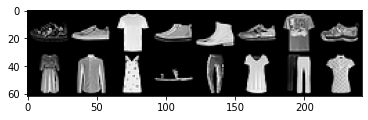

In [ ]:
def imgshow(img):
  #img = img/2 + 0.5 
  numpy_img = img.numpy()
  plt.imshow(np.transpose(numpy_img,(1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images[:16], nrow=8))

# Conv VAE Architecture

In [ ]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [ ]:
def KL_Loss(mu, logVar):
  return 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())

In [ ]:
def show_visual(imgs):

  img = np.transpose(np.reshape(imgs[0].clone().detach().cpu().numpy(), (1, 28, 28)), [1,2,0])
  plt.subplot(121)
  plt.imshow(np.squeeze(img), cmap="gray")
  out, mu, logVAR = model(imgs)
  outimg = np.transpose(np.reshape(out[0].clone().detach().cpu().numpy(), (1, 28, 28)), [1,2,0])
  plt.subplot(122)
  plt.imshow(np.squeeze(outimg), cmap="gray")
  plt.show()

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction='sum')
model

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (encFC1): Linear(in_features=12800, out_features=256, bias=True)
  (encFC2): Linear(in_features=12800, out_features=256, bias=True)
  (decFC1): Linear(in_features=256, out_features=12800, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [ ]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
#args = model path, history path
def train_or_load(model, perform, *args):

  if perform=="train":

    best_weights = copy.deepcopy(model.state_dict())
    best_val_loss = np.inf 
    stat_in_each_batch = 100
    EPOCHS = 5

    tr_loss_hist  = []
    val_loss_hist = []

    since = time.time()

    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        tr_running_loss = 0.0

        for i, data in tqdm(enumerate(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            tr_inputs, tr_labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            tr_outputs, tr_mu, tr_logvar = model(tr_inputs)

            loss = final_loss(criterion(tr_outputs, tr_inputs), tr_mu, tr_logvar)
            
            loss.backward()
            optimizer.step()

            # print statistics
            tr_running_loss += loss.item() 

            # #gpu memory clean
            tr_inputs.detach()
            tr_labels.detach()
            tr_outputs.detach()

            if (i+1) % stat_in_each_batch == 0:
              
              with torch.no_grad():
                v_loss = 0.0
                for j, data in enumerate(validloader):

                  v_inputs, v_labels = data[0].to(device), data[1].to(device)

                  v_outputs, v_mu, v_logvar = model(v_inputs)

                  loss = final_loss(criterion(v_outputs, v_inputs), v_mu, v_logvar)

                  v_loss += loss.item() 


              #visual after business is done
              show_visual(v_inputs)

              #placeholder
              val_loss  = v_loss / len(validloader.dataset)
              tr_loss   = tr_running_loss / (stat_in_each_batch*batch_size)

              #print stat
              print(f"\n Epoch: {epoch} Batch: {(i+1)} Train Loss: {tr_loss} Val Loss: {val_loss}")

              #save history
              tr_loss_hist.append(tr_loss)
              val_loss_hist.append(val_loss)

              #model state transfer
              if val_loss < best_val_loss:
                best_val_loss = val_loss 
                best_model_wts = copy.deepcopy(model.state_dict())

              #make sum = 0
              tr_running_loss = 0.0

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    #history
    # tr_acc_hist = [x.cpu().item() for x in tr_acc_hist]
    # val_acc_hist = [x.cpu().item() for x in val_acc_hist] 
    history = {"Training Loss": tr_loss_hist, "Validation Loss": val_loss_hist}

    #save model
    torch.save(model.state_dict(), args[0])

    #save history
    with open(args[1], 'wb') as f:
      pickle.dump(history, f)


  elif perform=="load":
    PATH = args[0]
    model.load_state_dict(torch.load(PATH))

    with open(args[1], 'rb') as f:
      history = pickle.load(f)

  return model, history





In [ ]:
#model path
model_PATH = './drive/MyDrive/ML Project Course/HW5/fmnist_CNNVAE.pth'
history_PATH = "./drive/MyDrive/ML Project Course/HW5/history_5_2_CNN.pkl"

You can visualize how during different batch steps the generated image quality improved

94it [00:01, 67.61it/s]

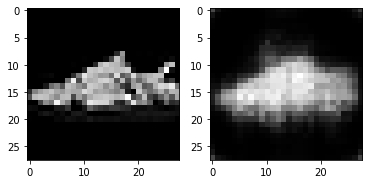

108it [00:02, 28.33it/s]


 Epoch: 0 Batch: 100 Train Loss: 352.5847412109375 Val Loss: 297.27622916666667


196it [00:03, 68.78it/s]

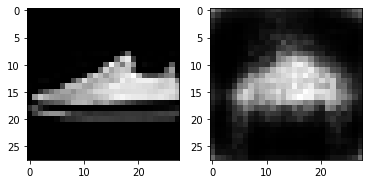

210it [00:04, 28.81it/s]


 Epoch: 0 Batch: 200 Train Loss: 288.5075979614258 Val Loss: 283.4657916666667


295it [00:05, 67.46it/s]

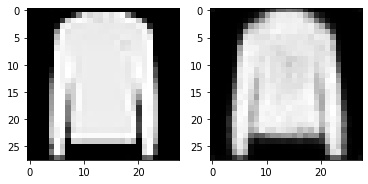

309it [00:06, 28.62it/s]


 Epoch: 0 Batch: 300 Train Loss: 278.84176055908205 Val Loss: 276.528625


397it [00:08, 67.62it/s]

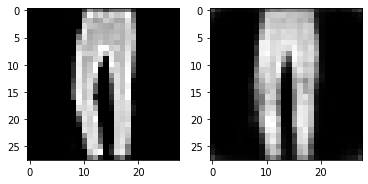

411it [00:08, 29.49it/s]


 Epoch: 0 Batch: 400 Train Loss: 273.3362803649902 Val Loss: 271.79664583333334


446it [00:09, 46.92it/s]
96it [00:01, 69.32it/s]

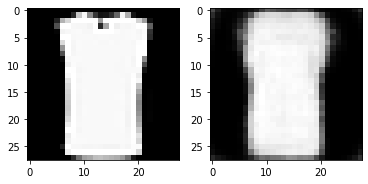

111it [00:02, 26.61it/s]


 Epoch: 1 Batch: 100 Train Loss: 266.31941848754883 Val Loss: 266.442


199it [00:03, 65.55it/s]

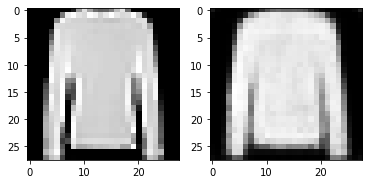

206it [00:04, 18.95it/s]


 Epoch: 1 Batch: 200 Train Loss: 263.82784057617187 Val Loss: 264.0725


295it [00:06, 64.67it/s]

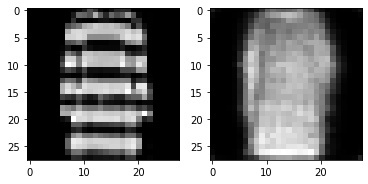

309it [00:07, 28.98it/s]


 Epoch: 1 Batch: 300 Train Loss: 260.78675659179686 Val Loss: 261.4555208333333


393it [00:08, 64.66it/s]

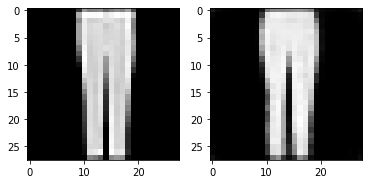

407it [00:09, 28.66it/s]


 Epoch: 1 Batch: 400 Train Loss: 258.38906463623044 Val Loss: 259.6627916666667


446it [00:09, 45.04it/s]
94it [00:01, 64.84it/s]

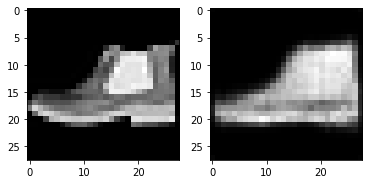

108it [00:02, 28.00it/s]


 Epoch: 2 Batch: 100 Train Loss: 256.3139109802246 Val Loss: 257.67175


194it [00:03, 63.56it/s]

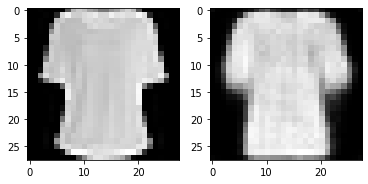

209it [00:04, 28.53it/s]


 Epoch: 2 Batch: 200 Train Loss: 255.26111114501953 Val Loss: 256.8600625


296it [00:05, 65.60it/s]

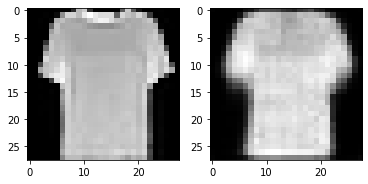

310it [00:06, 28.10it/s]


 Epoch: 2 Batch: 300 Train Loss: 254.73100479125978 Val Loss: 255.63291666666666


397it [00:08, 63.91it/s]

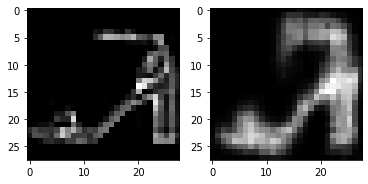

411it [00:09, 28.53it/s]


 Epoch: 2 Batch: 400 Train Loss: 253.56193496704103 Val Loss: 254.50297916666668


446it [00:09, 46.16it/s]
94it [00:01, 66.79it/s]

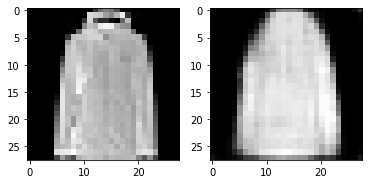

109it [00:02, 28.28it/s]


 Epoch: 3 Batch: 100 Train Loss: 252.11976287841796 Val Loss: 254.01091666666667


196it [00:03, 66.26it/s]

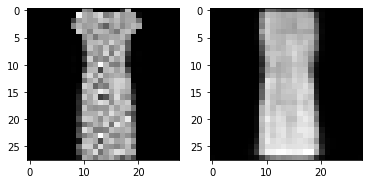

209it [00:04, 27.65it/s]


 Epoch: 3 Batch: 200 Train Loss: 251.16028610229492 Val Loss: 252.78770833333334


294it [00:05, 62.70it/s]

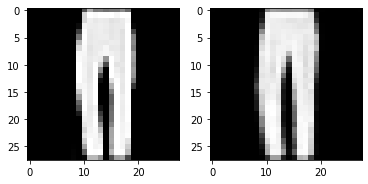

309it [00:06, 28.46it/s]


 Epoch: 3 Batch: 300 Train Loss: 251.51979049682618 Val Loss: 251.918


397it [00:08, 64.91it/s]

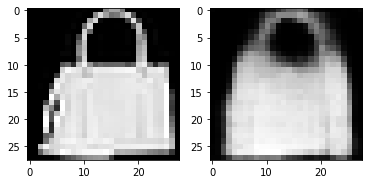

411it [00:09, 25.54it/s]


 Epoch: 3 Batch: 400 Train Loss: 249.65387908935546 Val Loss: 251.62625


446it [00:09, 45.50it/s]
99it [00:01, 66.21it/s]

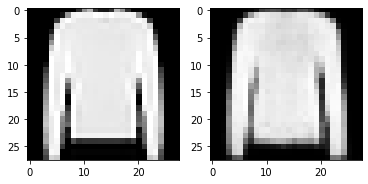

113it [00:03, 24.17it/s]


 Epoch: 4 Batch: 100 Train Loss: 250.00720977783203 Val Loss: 250.77552083333333


197it [00:04, 63.43it/s]

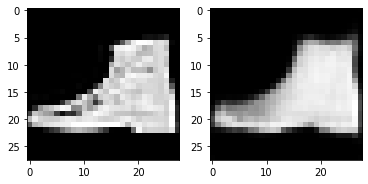

211it [00:05, 27.36it/s]


 Epoch: 4 Batch: 200 Train Loss: 248.9409440612793 Val Loss: 250.379375


297it [00:06, 63.53it/s]

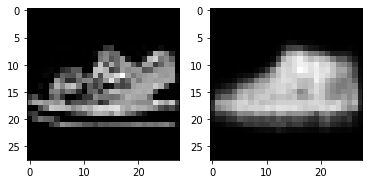

311it [00:07, 27.77it/s]


 Epoch: 4 Batch: 300 Train Loss: 249.19144592285156 Val Loss: 249.80008333333333


396it [00:08, 63.22it/s]

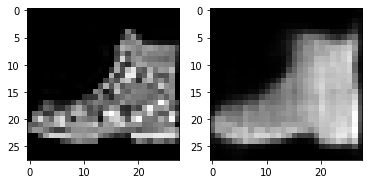

410it [00:09, 27.01it/s]


 Epoch: 4 Batch: 400 Train Loss: 246.84110549926757 Val Loss: 249.4343125


446it [00:10, 43.21it/s]


Training complete in 0m 50s
Best Validation Loss: 249.434313


In [ ]:
model, history = train_or_load(model, "train", *[model_PATH, history_PATH])

Randomly visualize several image reconstructions from Test Data

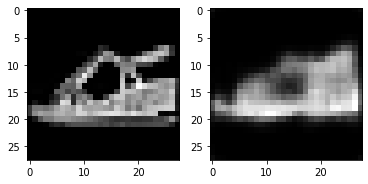

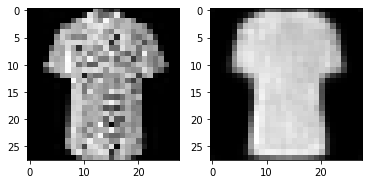

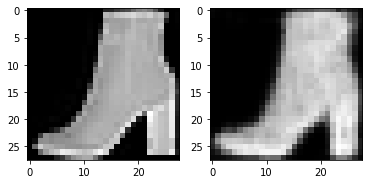

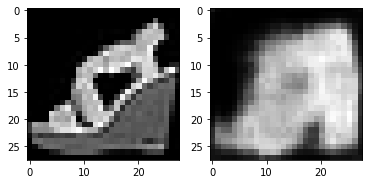

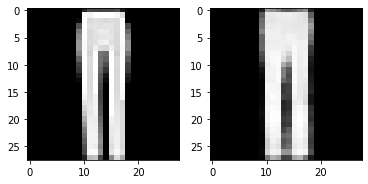

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

model.eval()
with torch.no_grad():
  for i in range(5):
    for data in random.sample(list(testloader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        show_visual(imgs)

#Plot History

In [ ]:
history.keys()

dict_keys(['Training Loss', 'Validation Loss'])

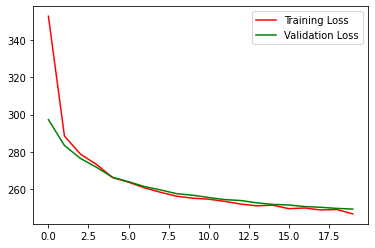

In [ ]:
plt.plot(history["Training Loss"], label="Training Loss", color="red")
plt.plot(history["Validation Loss"], label="Validation Loss", color="green")
plt.legend()
plt.show()

Dataset: Fashion MNIST https://pytorch.org/vision/stable/datasets.html#fashion-mnist \\
References: 
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/ 
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html 
- https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html 
- https://pytorch.org/vision/stable/transforms.html